In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers, optimizers, metrics, losses, applications as apps, callbacks as cbs
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    with_info=True,
    split=['train', 'test'],
    read_config=tfds.ReadConfig(try_autocache=False)
)

2022-02-07 14:13:22.594637: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-train.tfrecord...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling oxford_iiit_pet-test.tfrecord...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


2022-02-07 14:14:17.483365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 14:14:17.655080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 14:14:17.655917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-07 14:14:17.659790: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
itr = iter(train_ds)
next(itr)

2022-02-07 14:14:20.391539: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


{'file_name': <tf.Tensor: shape=(), dtype=string, numpy=b'Sphynx_158.jpg'>,
 'image': <tf.Tensor: shape=(500, 500, 3), dtype=uint8, numpy=
 array([[[ 3,  3,  3],
         [ 5,  3,  4],
         [ 7,  5,  6],
         ...,
         [ 3,  1,  2],
         [ 3,  1,  2],
         [ 3,  1,  2]],
 
        [[ 4,  3,  1],
         [ 5,  3,  4],
         [ 5,  3,  4],
         ...,
         [ 6,  2,  3],
         [ 7,  3,  4],
         [ 8,  4,  5]],
 
        [[ 4,  3,  1],
         [ 5,  4,  2],
         [ 5,  3,  4],
         ...,
         [ 7,  3,  2],
         [ 8,  4,  3],
         [ 8,  4,  3]],
 
        ...,
 
        [[ 6, 10, 11],
         [ 6,  7,  9],
         [ 7,  8, 10],
         ...,
         [ 3,  4,  6],
         [ 3,  4,  6],
         [ 4,  5,  7]],
 
        [[ 8, 12, 13],
         [ 7,  8, 10],
         [ 8,  9, 11],
         ...,
         [ 4,  5,  9],
         [ 4,  5,  7],
         [ 4,  5,  7]],
 
        [[ 8, 12, 13],
         [ 7,  8, 10],
         [ 8,  9, 11],
  

In [4]:
# Dataset image size
IMG_SIZE = 128

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1
    
    return image, mask

def preprocess(item):
    image, mask = item['image'], item['segmentation_mask']
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE])
    image, mask = normalize(image, mask)
    
    return image, mask

train_prep_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_prep_ds = test_ds.map(preprocess)

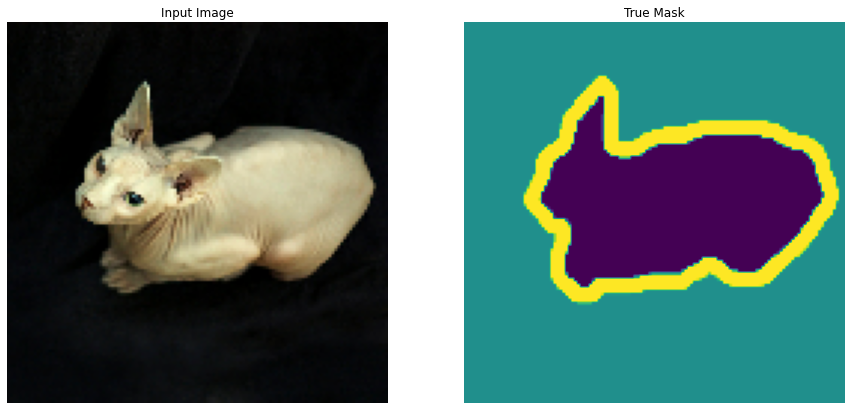

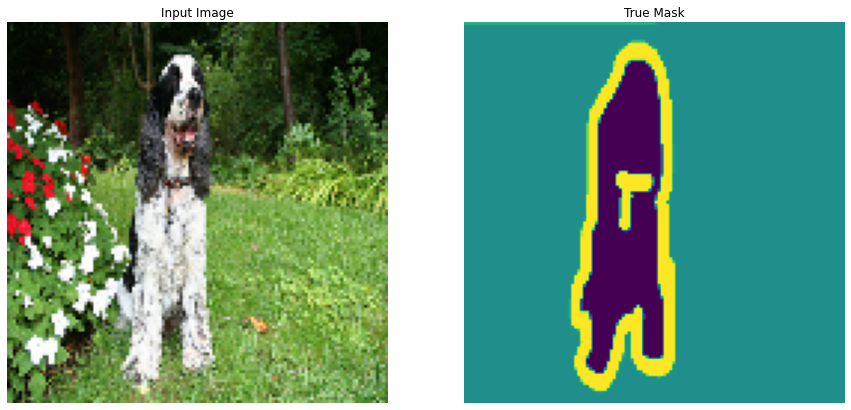

In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train_prep_ds.take(2):
    display([image, mask])

In [6]:
DROPOUT_RATE = 0.2
LEARNING_RATE = 0.001
N_CLASSES = 3

layer_id = -1

def get_conv_block(num_channels, shape=(3,3), padding='same', **kwargs):
    global layer_id
    layer_id += 1
    return tf.keras.Sequential(
        [
            layers.Conv2D(num_channels, shape, padding=padding, **kwargs),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='conv_block' + str(layer_id)
    )

def get_conv_dsc_block(num_channels, shape=(3,3), padding='same', **kwargs):
    global layer_id
    layer_id += 1

    return tf.keras.Sequential(
        [
            layers.DepthwiseConv2D(shape, padding=padding, **kwargs),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(num_channels, (1,1), padding=padding, strides=1),
            layers.BatchNormalization(),
            layers.ReLU(),
        ],
        name='conv_dsc_block' + str(layer_id)
    )

def get_conv_builder(layer_type='standard'):
    if (layer_type == 'standard'):
        return get_conv_block
    elif (layer_type == 'dsc'):
        return get_conv_dsc_block
    else:
        raise Error('Invalid layer type: ', layer_type)

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    return tf.keras.Sequential([
        layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU()
    ])

def create_model(conv_type='standard'):
    conv_block = get_conv_builder(conv_type)
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        get_conv_block(32, strides=2),
        conv_block(64, strides=1),
        conv_block(128, strides=2),
        conv_block(128, strides=1),
        conv_block(256, strides=2),
        conv_block(256, strides=1),
        conv_block(512, strides=2),
        conv_block(512, strides=1),
        conv_block(512, strides=1),
        conv_block(512, strides=1),
        conv_block(512, strides=1),
        conv_block(512, strides=1),
        conv_block(1024, strides=2),
        upsample(512, 3),
        upsample(256, 3),
        upsample(128, 3),
        upsample(64, 3),
        upsample(3, 3),
    ])
    
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
    
    return model

# model = create_model(conv_type='dsc')
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block0 (Sequential)     (None, 64, 64, 32)        1024      
_________________________________________________________________
conv_block1 (Sequential)     (None, 64, 64, 64)        18752     
_________________________________________________________________
conv_block2 (Sequential)     (None, 32, 32, 128)       74368     
_________________________________________________________________
conv_block3 (Sequential)     (None, 32, 32, 128)       148096    
_________________________________________________________________
conv_block4 (Sequential)     (None, 16, 16, 256)       296192    
_________________________________________________________________
conv_block5 (Sequential)     (None, 16, 16, 256)       591104    
_________________________________________________________________
conv_block6 (Sequential)     (None, 8, 8, 512)        

In [7]:
def train(model, tds, vds, epochs=100, callbacks=[]):
    tds = tds.prefetch(buffer_size=tf.data.AUTOTUNE)
    vds = vds.prefetch(buffer_size=tf.data.AUTOTUNE) if vds else None
    history = model.fit(tds, validation_data=vds, epochs=epochs, callbacks=callbacks)

    return history

In [8]:
checkpoint_name_tmpl = 'dsc_conv/weights-epoch-{epoch:d}-val_accuracy-{val_accuracy:.4f}.h5'
checkpoint = cbs.ModelCheckpoint(checkpoint_name_tmpl, save_best_only=True, monitor="val_accuracy")

EPOCHS = 50
BATCH_SIZE = 16

callbacks = [checkpoint]
tds = train_prep_ds.cache().shuffle(1000, reshuffle_each_iteration=True).batch(BATCH_SIZE)
vds = test_prep_ds.batch(256).cache()

train(model, tds, vds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/50


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2022-02-07 14:14:27.972340: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


230/230 [==============================] - 34s 97ms/step - loss: 0.8397 - accuracy: 0.6338 - val_loss: 1.0259 - val_accuracy: 0.5703
Epoch 2/50
230/230 [==============================] - 12s 50ms/step - loss: 0.7491 - accuracy: 0.6747 - val_loss: 0.9641 - val_accuracy: 0.5836
Epoch 3/50
230/230 [==============================] - 11s 50ms/step - loss: 0.6916 - accuracy: 0.6969 - val_loss: 0.9800 - val_accuracy: 0.5938
Epoch 4/50
230/230 [==============================] - 12s 50ms/step - loss: 0.6502 - accuracy: 0.7077 - val_loss: 0.7066 - val_accuracy: 0.6749
Epoch 5/50
230/230 [==============================] - 12s 50ms/step - loss: 0.6101 - accuracy: 0.7208 - val_loss: 0.7729 - val_accuracy: 0.6676
Epoch 6/50
230/230 [==============================] - 11s 50ms/step - loss: 0.5727 - accuracy: 0.7334 - val_loss: 0.5828 - val_accuracy: 0.7284
Epoch 7/50
230/230 [==============================] - 11s 50ms/step - loss: 0.5399 - accuracy: 0.7484 - val_loss: 0.7897 - val_accuracy: 0.6648
Epo